## Getting contours of active regions 

Archive of the Kislovodsk Mountain Astronomical Station contains long-term series of various active regions. You can investigate them visually at [https://observethesun.com/](https://observethesun.com/). The function ```get_kislovodsk_data``` downloads the contours of the active ragions to your computer as numerical arrays so that you can work with them.

If you have no time to read the further instructions, just run the code below to get the data:

In [1]:
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore') #to ignore the astropy warnings

from helio import get_kislovodsk_data

get_kislovodsk_data(series='ch', #'spot' for sunspots, 'ca' plages, 'fil' filaments, 'ch' coronal holes
                    start_date='2022-12-01', #YYYY-MM-DD
                    end_date='2022-12-31', #YYYY-MM-DD
                    path='./contours') #set the path to the existing local directory

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 16.86s/it]


### Description of the data format

There are four types of active regions available in the archive and you have to indicate one of them as the first parameter of the function:
* sunspots (series='SPOT')
* filaments (series='FIL')
* plages (series='CA')
* coronal holes (series='CH')

The parameters ```start_date``` and ```end_date``` limit the time series to the given dates, for example, to get data for the whole year 2022 set ```start_date='2022-01-01'``` and ```end_date='2022-12-31'```.

One more required parameter is the ```path```  to the local directory where the files will be stored.

Run the function and once the process is completed, you will find a number of files in ```.json``` format that contain controus and some additional parameters of active regions. The ```.json``` files have the following structure:

```python
{'data': [{'vetrtices': [[lat_1, lon_1], [lat_2, lon_2], ..., [lat_n, lon_n]],
           'area': area,
           'area_units': 'millionth of the solar hemisphere',
           'perimeter': p,
           'bbox': (lat_min, lon_min, lat_max, lon_max),
           'bbox_center': (lat, lon),
           'dlat': dlat,
           'dlon', dlon,
           'deg': true,
           },
          {'vetrtices': [[lat_1, lon_1], ...],
           ...},
          ...,
          {'vetrtices': [[lat_1, lon_1], ...],
           ...}]
}
 ```
 
The key `data` contains a list of active regions. Each active region is represented by a list of polygon vertices. Note that the first and the last vertices are the always same. Then we have a number of paramerets of active region:
* area in millionth of the solar hemisphere
* perimeter in radians
* bounding box
* the center of the bounding box
* latitudinal extent (`dlat`)
* longitudinal extent (`dlon`)
* angle units (degrees)

In Python, one can read these json files as simple as
```python
import json

with open('path/to/file.json') as f:
    data = json.load(f)['data']
```
however, below we show a more useful approach.

### Data processing with the `helio` framework

Before reading further, we recommend reading the previous tutorial [1.Basic_concepts.ipynb](1.Basic_concepts.ipynb) to learn the basic concepts of the `helio` framework. We start with
indexing of the files that should be processed:

In [2]:
import sys
sys.path.append("..")

from helio import FilesIndex, HelioBatch

index = (FilesIndex(path='./contours/*', name='CH')
         .parse_datetime()
         .get_sun_params())
index.head()

,CH,DateTime,L0,B0,CR
FilesIndex,,,,,
CH_2022-12-01T040416,./contours\CH_2022-12-01T040416.json,2022-12-01 04:04:16,51.159587,0.897323,2264
CH_2022-12-02T034916,./contours\CH_2022-12-02T034916.json,2022-12-02 03:49:16,38.117945,0.771540,2264
CH_2022-12-03T031916,./contours\CH_2022-12-03T031916.json,2022-12-03 03:19:16,25.213760,0.646815,2264
CH_2022-12-04T050428,./contours\CH_2022-12-04T050428.json,2022-12-04 05:04:28,11.072453,0.509875,2264
CH_2022-12-05T031916,./contours\CH_2022-12-05T031916.json,2022-12-05 03:19:16,358.856869,0.391401,2265


Now one can read all files using the `HelioBatch.load()` method.
Note that for a large collection of files, reading all the files at once may run out of memory. In this case, we recommend iterating over a list of files with small subsets of files using `BatchSampler`. At the end of this tutorial you will find an example usage.


In [3]:
batch = HelioBatch(index).load(src='CH')

Now each file with a list of active regions is stored in batch items. For example, the first batch item contains three active regions: 

In [4]:
batch.CH[0]

One can access vertices of each polygon:

In [5]:
batch.CH[0][0].vertices

array([[  8.84, 358.88],
       [  8.85, 359.11],
       [  8.99, 359.09],
       ...,
       [  8.56, 358.94],
       [  8.7 , 358.91],
       [  8.84, 358.88]])

One can also get parameters of each polygon:

In [6]:
poly = batch.CH[0][0]
print('Area', poly.area)
print('Perimeter', poly.perimeter)
print('bbox', poly.bbox)
print('bbox center', poly.bbox_center)
print('dlat', poly.dlat)
print('dlon', poly.dlon)

Area 6373.338136039191
Perimeter 1.4865861092727308
bbox (-4.04, 359.97, 16.11, 0.13)
bbox center (6.035, 0.05000000000001137)
dlat 20.15
dlon 0.15999999999996817


Below we show how to plot the contours of active regions. For illustration, we show three successive
days and use different colors for each day:

<AxesSubplot:>

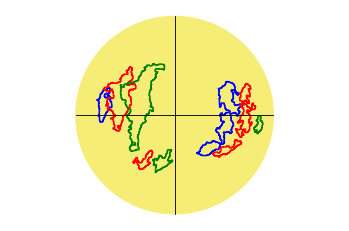

In [7]:
# %matplotlib notebook # uncomment this line to enable the interactive plot
i = 0 # positional index of batch item to show
ax = batch.show_sun('CH', i)
batch.show_sun('CH', i+1, c='r', ax=ax)
batch.show_sun('CH', i+2, c='g', ax=ax)

Next step is to process each file to collect total area and perimeter for each day.
Here we use `BatchSampler` to iterate over a possible large list of files with small subsets of files (``batch_size=10``). At each iteration we read the next subset of files and collect total area and perimeter in each file. The total values are accumulated in the pandas DataFrame.

In [8]:
from helio import BatchSampler
import pandas as pd

sampler = BatchSampler(index, batch_size=10)
dfs = []
for ids in sampler:
    batch = HelioBatch(ids).load(src='CH')
    batch.apply(lambda item: sum(poly.area for poly in item), src='CH', dst='area')
    batch.apply(lambda item: sum(poly.perimeter for poly in item), src='CH', dst='perim')
    dfs.append(pd.DataFrame(dict(Date=ids.DateTime.values,
                                 Area=batch.area,
                                 Perimeter=batch.perim)))
df = pd.concat(dfs)
df.head()

,Date,Area,Perimeter
0,2022-12-01 04:04:16,23169.6,5.61142
1,2022-12-02 03:49:16,32735.6,8.82354
2,2022-12-03 03:19:16,32718.7,5.89684
3,2022-12-04 05:04:28,37745.4,7.3037
4,2022-12-05 03:19:16,33944.4,7.5722


Now we can plot e.g. the variation of the total area of active regions:

<AxesSubplot:xlabel='Date', ylabel='MSH'>

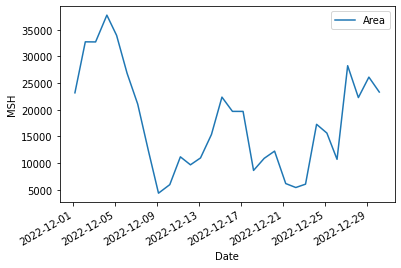

In [9]:
df.plot(x='Date', y='Area', ylabel='MSH')

In the next tutorials we will show more advanced data processing tools.